# ***Sentiment Analysis w Transformers***

https://www.kaggle.com/code/emirkocak/in-depth-series-sentiment-analysis-w-transformers/notebook

In [1]:
# Loading Dependencies
#Importing data

import warnings
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings("ignore")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai.vision.all import *
from fastai import *
from fastai.text import *
import fastai.callback.all
from fastai.callback import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

In [4]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 2.7.9
transformers version : 4.22.1


In [133]:
# LOADING THE DATA
import pandas as pd
train = pd.read_csv("/content/drive/MyDrive/train.tsv", sep='\t')
validation = pd.read_csv("/content/drive/MyDrive/dev.tsv", sep='\t')
test = pd.read_csv("/content/drive/MyDrive/test_task2.tsv", sep='\t')

# ***Preprocessing***

In [134]:
train = train.rename({'label ': 'label'}, axis=1) #Rename the column label
validation = validation.rename({'label ': 'label'}, axis=1) #Rename the column label

In [7]:
train = train[~train.label.str.contains("others")]
train = train[~train.label.str.contains("disgust")]
train['label'].value_counts()

joy          1270
sadness       706
anger         600
surprise      241
fear           67
Name: label, dtype: int64

In [135]:
validation = validation[~validation.label.str.contains("others")]
validation = validation[~validation.label.str.contains("disgust")]
validation['label'].value_counts()

joy          185
sadness      103
anger         87
surprise      35
fear          10
Name: label, dtype: int64

In [9]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import nltk

In [11]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
import re,string

In [13]:
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

In [14]:
def strip_all_entities(text):
    entity_prefixes = ['@','#', '¿', '¡']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [136]:
train['tweet'] = train['tweet'].apply(lambda x: strip_links(x))
validation['tweet'] = validation['tweet'].apply(lambda x: strip_links(x))

In [137]:
train['tweet'] = train['tweet'].apply(lambda x: strip_all_entities(x))
validation['tweet'] = validation['tweet'].apply(lambda x: strip_all_entities(x))

In [138]:
train['tweet'] = train['tweet'].str.replace(r'HASHTAG', '', regex=True)
train['tweet'] = train['tweet'].str.replace(r'USER', '', regex=True)

validation['tweet'] = validation['tweet'].str.replace(r'HASHTAG', '', regex=True)
validation['tweet'] = validation['tweet'].str.replace(r'USER', '', regex=True)

In [139]:
def convert_to_lower(text):
    return text.lower()

In [140]:
train['tweet'] = train['tweet'].apply(lambda x: convert_to_lower(x))
validation['tweet'] = validation['tweet'].apply(lambda x: convert_to_lower(x))

In [20]:
def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

In [141]:
train['tweet'] = train['tweet'].apply(lambda x: remove_numbers(x))
validation['tweet'] = validation['tweet'].apply(lambda x: remove_numbers(x))

In [22]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [142]:
train['tweet'] = train['tweet'].apply(lambda x: remove_punctuation(x))
validation['tweet'] = validation['tweet'].apply(lambda x: remove_punctuation(x))

In [24]:
from nltk import word_tokenize #method that will perform text tokenization.

In [25]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
stopword_es = nltk.corpus.stopwords.words('spanish')
stopword = stopword_es

def remove_stopwords(text):
    removed = []
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] not in stopword:
            removed.append(tokens[i])
    return " ".join(removed)

In [143]:
train['tweet'] = train['tweet'].apply(lambda x: remove_stopwords(x))
validation['tweet'] = validation['tweet'].apply(lambda x: remove_stopwords(x))

In [28]:
def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

In [144]:
train['tweet'] = train['tweet'].apply(lambda x: remove_extra_white_spaces(x))
validation['tweet'] = validation['tweet'].apply(lambda x: remove_extra_white_spaces(x))

In [30]:
pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import emoji

In [32]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                    u"\U0001F600-\U0001F64F" #emoticons
                    u"\U0001F300-\U0001F5FF" #symbols and pictographs
                    u"\U0001F680-\U0001F6FF" #transport and map symbols
                    u"\U0001F1E0-\U0001F1FF" #flags (ios)
                    u"\U00002702-\U000027B0" 
                    u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [145]:
train['tweet'] = train['tweet'].apply(lambda x: remove_emoji(x))
validation['tweet'] = validation['tweet'].apply(lambda x: remove_emoji(x))

In [34]:
pip install clean-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
from cleantext import clean
train['tweet'] = train['tweet'].apply(lambda x: clean(x, no_emoji = True))
validation['tweet'] = validation['tweet'].apply(lambda x: clean(x, no_emoji = True))

In [36]:
label_map = {
    'joy ': 0,
    'sadness ': 1,
    'anger ': 2,
    'surprise ': 3,
    'fear ': 4,
}

train['label'] = train['label'].map(label_map)
train

,id,tweet,label
0,1,atletico resignado perder,1
1,2,leer proporciona mejor vision mundo,0
2,3,amo arya stark encima todas cosas gameofthrones,0
4,5,solo siento perdido escanos cordura,1
5,6,solo ver intensidad agitan banderas ve quedado satisfechos sinceramente alegro muchisimo,0
...,...,...,...
5879,5880,imposible ver melisandre podria invernalia teoria demuestra via,3
5882,5883,dos coronaciones celebraron napoleon unico caso monarca coronado rey francia rey inglaterra historia enrique vi,3
5883,5884,mientras reflexionamos duro medio nueva guerra fria pleno siglo xxi silencio realmente escandaloso,2
5884,5885,"fachada catedral notre dame "" salvada "" podra restaurar techo obras vitrales sufrieron grandes afectaciones checa toda info",1


In [37]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Main transformers classes
In transformers, each model architecture is associated with 3 main types of classes:

A model class to load/store a particular pre-train model.
A tokenizer class to pre-process the data and make it compatible with a particular model.
A configuration class to load/store the configuration of a particular model.
For example, if you want to use the Bert architecture for text classification, you would use BertForSequenceClassification for the model class, BertTokenizer for the tokenizer class and BertConfig for the configuration class. 

Visualizations

Word Cloud
Word clouds generators work by breaking the text down into component words and counting how frequently they appear in the body of text. We can quickly obtain preliminary information about the data. We can understand what a dataset we don't know is talking about.

In [68]:
from wordcloud import WordCloud 

In [66]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40, 
        scale=1,
        random_state=1
).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

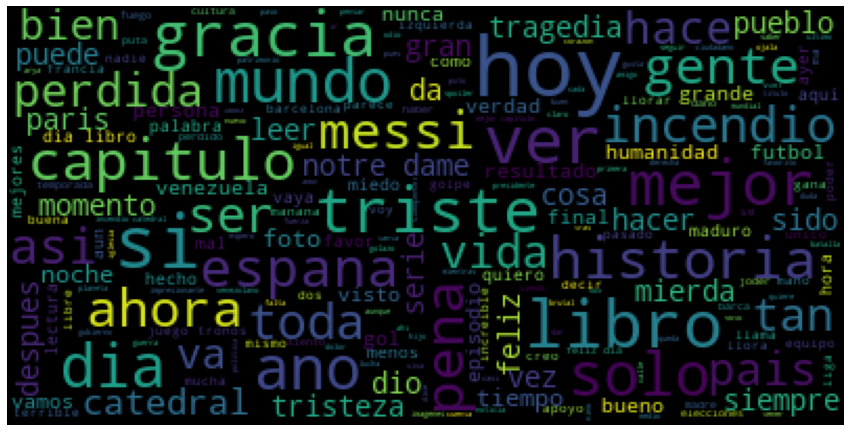

In [69]:
show_wordcloud(train["tweet"].values)

Target Count

In [70]:
import pandas as pd
from wordcloud import WordCloud
import seaborn as sns
import re
import string
from collections import Counter, defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

How many targets do we have? Learning this information will give us an idea about the model we will build. It will also provide guidance on our methods of analyzing data

In [74]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]])
colors = ['gold', 'mediumturquoise', 'lightgreen'] # darkorange
fig.add_trace(go.Pie(labels=train.label.value_counts().index,
                             values=train.label.value_counts().values), 1, 1)

fig.update_traces(hoverinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.add_trace(go.Bar(x=train.label.value_counts().index, y=train.label.value_counts().values, marker_color = colors), 1,2)

fig.show()

# ***Token Counts with simple tokenizer***
Finding out the number of tokens available for each sample will give us information about the length of our data. The classification algorithm we will use for a long text will not be the same as the algorithm used for a short text.

In [75]:
def tokenize(text):
    """ basic tokenize method with word character, non word character and digits """
    text = re.sub(r" +", " ", str(text))
    text = re.split(r"(\d+|[a-zA-ZğüşıöçĞÜŞİÖÇ]+|\W)", text)
    text = list(filter(lambda x: x != '' and x != ' ', text))
    sent_tokenized = ' '.join(text)
    return sent_tokenized

In [76]:
# tokenize data
train["tokenized_tweet"] = train.tweet.apply(lambda x: tokenize(x))
# calculate token count for any sent
train["sent_token_length"] = train["tokenized_tweet"].apply(lambda x: len(x.split()))

In [78]:
fig = px.histogram(train, x="sent_token_length", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")
fig.show()

In [79]:
(train.sent_token_length < 512).mean()

1.0

# ***Token Counts with BERT tokenizer***
Since we will create a Transformers-based model, the value that BERT tokinezer will give us is very important. With the information here, the value of the seq_len parameter that we will use while encoding the data will be decided.

In [80]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [81]:
# data tokenize with bert tokenizer
train["sent_bert_token_length"] = train["tweet"].apply(lambda x: len(tokenizer(x, add_special_tokens=False)["input_ids"]))

In [83]:
fig = px.histogram(train, x="sent_token_length", nbins=20, color_discrete_sequence=px.colors.cmocean.algae, barmode='group', histnorm="percent")
fig.show()

Most Common Words

In [91]:
from nltk.corpus import stopwords
stopWords_nltk = set(stopwords.words('spanish'))

In [92]:
texts = train['tokenized_tweet']
new = texts.str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]
counter = Counter(corpus)
most = counter.most_common()
x, y = [], []
for word, count in most[:30]:
    if word not in stopWords_nltk:
        x.append(word)
        y.append(count)

fig = go.Figure(go.Bar(
            x=y,
            y=x,
            orientation='h',  marker=dict(
        color='rgba(50, 171, 96, 0.6)',
        line=dict(
            color='rgba(50, 171, 96, 1.0)',
            width=1),
    ),
    name='Most common Word',))

fig.update_layout( title={
        'text': "Most Common Words",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}, font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ))

fig.show()

# ***MODELS***

In [106]:
import pandas as pd
import numpy as np
import os
import random
from pathlib import Path
import json

In [107]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [108]:
class Config():
    seed_val = 17
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    epochs = 5 
    batch_size = 6
    seq_length = 512
    lr = 2e-5
    eps = 1e-8
    pretrained_model = 'bert-base-uncased'
    test_size=0.15
    random_state=42
    add_special_tokens=True 
    return_attention_mask=True 
    pad_to_max_length=True 
    do_lower_case=False
    return_tensors='pt'

config = Config()

In [109]:
# params will be saved after training
params = {"seed_val": config.seed_val,
    "device":str(config.device),
    "epochs":config.epochs, 
    "batch_size":config.batch_size,
    "seq_length":config.seq_length,
    "lr":config.lr,
    "eps":config.eps,
    "pretrained_model": config.pretrained_model,
    "test_size":config.test_size,
    "random_state":config.random_state,
    "add_special_tokens":config.add_special_tokens,
    "return_attention_mask":config.return_attention_mask,
    "pad_to_max_length":config.pad_to_max_length,
    "do_lower_case":config.do_lower_case,
    "return_tensors":config.return_tensors,
         }

In [110]:
# set random seed and device
import random

device = config.device

random.seed(config.seed_val)
np.random.seed(config.seed_val)
torch.manual_seed(config.seed_val)
torch.cuda.manual_seed_all(config.seed_val)

BertTokenizer and Encoding the Data

In [111]:
# create tokenizer
tokenizer = BertTokenizer.from_pretrained(config.pretrained_model, 
                                          do_lower_case=config.do_lower_case)

In [112]:
encoded_data_train = tokenizer.batch_encode_plus(
    train.tweet.values, 
    add_special_tokens=config.add_special_tokens, 
    return_attention_mask=config.return_attention_mask, 
    pad_to_max_length=config.pad_to_max_length, 
    max_length=config.seq_length, 
    return_tensors=config.return_tensors
)
encoded_data_val = tokenizer.batch_encode_plus(
    validation.tweet.values, 
    add_special_tokens=config.add_special_tokens, 
    return_attention_mask=config.return_attention_mask, 
    pad_to_max_length=config.pad_to_max_length,
    max_length=config.seq_length, 
    return_tensors=config.return_tensors
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [113]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(validation.label.values)

In [114]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

***Creating the Model***

bert-base-uncased is a smaller pre-trained model.
Using num_labels to indicate the number of output labels.

In [115]:
model = BertForSequenceClassification.from_pretrained(config.pretrained_model,
                                                      num_labels=5,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Data Loaders

DataLoader combines a dataset and a sampler, and provides an iterable over the given dataset.
We use RandomSampler for training and SequentialSampler for validation.
Given the limited memory in my environment, I set batch_size=64.

In [116]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=config.batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=config.batch_size)

Optimizer & Scheduler

In [117]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=config.lr, 
                  eps=config.eps)
                  

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*config.epochs)

### ***Performance Metrics***
We will use f1 score as performance metric

In [119]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

# ***Training Loop***

In [120]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(config.device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        
    # calculate avareage val loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [121]:
config.device

device(type='cuda', index=0)

In [122]:
model.to(config.device)
    
for epoch in tqdm(range(1, config.epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    # allows you to see the progress of the training 
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(config.device) for b in batch)
        
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    
    tqdm.write(f'F1 Score (Weighted): {val_f1}');
# save model params and other configs 
with Path('params.json').open("w") as f:
    json.dump(params, f, ensure_ascii=False, indent=4)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/481 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.181379936589025
Validation loss: 0.9837614747030394
F1 Score (Weighted): 0.5985792470925251


Epoch 2:   0%|          | 0/481 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.811569021995375
Validation loss: 0.8856895530862468
F1 Score (Weighted): 0.6572086451277779


Epoch 3:   0%|          | 0/481 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.5791934414451124
Validation loss: 1.079878130794636
F1 Score (Weighted): 0.6836855338551117


Epoch 4:   0%|          | 0/481 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.3893569769326156
Validation loss: 1.2314892668742687
F1 Score (Weighted): 0.7006124377663737


Epoch 5:   0%|          | 0/481 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.2621870569849925
Validation loss: 1.3918538669589906
F1 Score (Weighted): 0.7054107299137365


***Test on validation set***

In [123]:
model.load_state_dict(torch.load(f'./_BERT_epoch_3.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [124]:
from sklearn.metrics import classification_report

preds_flat = np.argmax(predictions, axis=1).flatten()
print(classification_report(preds_flat, true_vals))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81       202
           1       0.70      0.73      0.72        98
           2       0.63      0.65      0.64        85
           3       0.29      0.38      0.33        26
           4       0.50      0.56      0.53         9

    accuracy                           0.71       420
   macro avg       0.59      0.62      0.60       420
weighted avg       0.73      0.71      0.72       420



ERROR ANALYSIS

In [146]:
# step by step predictions on dataframe
# We do this to view predictions in the pandas dataframe and easily filter them and perform error analysis.

pred_final = []

for i, row in tqdm(validation.iterrows(), total=validation.shape[0]):
    predictions = []

    review = row["tweet"]
    encoded_data_test_single = tokenizer.batch_encode_plus(
    [review], 
    add_special_tokens=config.add_special_tokens, 
    return_attention_mask=config.return_attention_mask, 
    pad_to_max_length=config.pad_to_max_length, 
    max_length=config.seq_length,
    return_tensors=config.return_tensors
    )
    input_ids_test = encoded_data_test_single['input_ids']
    attention_masks_test = encoded_data_test_single['attention_mask']

    
    inputs = {'input_ids':      input_ids_test.to(device),
              'attention_mask':attention_masks_test.to(device),
             }

    with torch.no_grad():        
        outputs = model(**inputs)
    
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)
    predictions = np.concatenate(predictions, axis=0)
    pred_final.append(np.argmax(predictions, axis=1).flatten()[0])

  0%|          | 0/420 [00:00<?, ?it/s]

In [147]:
# add pred into val_df
validation["pred"] = pred_final

In [148]:
#  Add control column for easier wrong and right predictions
control = validation.pred.values == validation.label.values
validation["control"] = control

In [149]:
# filtering false predictions
validation = validation[validation.control == False]

In [150]:
# label to intent mapping
name2label = {
    'joy ': 0,
    'sadness ': 1,
    'anger ': 2,
    'surprise ': 3,
    'fear ': 4,
}
label2name = {v: k for k, v in name2label.items()}


validation["pred_name"] =validation.pred.apply(lambda x: label2name.get(x)) 

In [151]:
from sklearn.metrics import confusion_matrix

# We create a confusion matrix to better observe the classes that the model confuses.
pred_name_values = validation.pred_name.values
label_values = validation.label.values
confmat = confusion_matrix(label_values, pred_name_values, labels=list(name2label.keys()))

In [152]:
confmat

array([[150,   9,  12,  14,   0],
       [ 14,  72,  10,   7,   0],
       [ 13,  15,  49,  10,   0],
       [ 17,   3,   4,  11,   0],
       [  1,   0,   2,   7,   0]])

In [153]:
df_confusion_val = pd.crosstab(label_values, pred_name_values)
df_confusion_val

col_0,anger,joy,sadness,surprise
row_0,,,,
anger,49,13,15,10
fear,2,1,0,7
joy,12,150,9,14
sadness,10,14,72,7
surprise,4,17,3,11
